In [1]:
import os
os.chdir("..")

In [2]:
import pickle

import numpy as np
np.random.seed(1234)

from tqdm import tqdm
from functools import partial
import itertools as it

# Plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from hips.plotting.colormaps import gradient_cmap
from hips.plotting.layout import create_axis_at_location
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

from matplotlib.cm import get_cmap
cm = get_cmap("cubehelix")
zimmer_colors = [cm(i) for i in np.linspace(0.05, 0.95, 8)]

from zimmer.io import load_kato_data
import zimmer.plotting as zplt

%matplotlib inline

In [117]:
# LDS Results
lds_dir = os.path.join("results", "kato", "2018-03-16-hlds", "run001")
signal = "dff_diff"
assert os.path.exists(lds_dir)

# AR-HMM RESULTS
results_dir = os.path.join("results", "kato", "2018-03-16-arhmm", "run001_etasq_0.01")
assert os.path.exists(results_dir)

fig_dir = os.path.join(results_dir, "figures")
mov_dir = os.path.join(results_dir, "movies")


In [118]:
# Load the continuous states found with the LDS
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=True)
D_obs = ys[0].shape[1]
with open(os.path.join(lds_dir, "lds_data.pkl"), "rb") as f:
    lds_results = pickle.load(f)

D_latent = lds_results['D_latent']
xtrains = lds_results['xtrains']
xtests = lds_results['xtests']
xs = [np.vstack((xtr, xte)) for xtr, xte in zip(xtrains, xtests)]

z_true_trains = lds_results['z_true_trains']
z_true_tests = lds_results['z_true_tests']
z_trues = [np.concatenate((ztr, zte)) for ztr, zte in zip(z_true_trains, z_true_tests)]
z_key = lds_results['z_key']

T_trains = np.array([xtr.shape[0] for xtr in xtrains])
T_tests = np.array([xte.shape[0] for xte in xtests])
Ts = [Ttr + Tte for Ttr, Tte in zip(T_trains, T_tests)]

C = lds_results['best_model'].C[:, lds_results['perm']]
d = lds_results['best_model'].D[:, 0]
ys_preds = [x.dot(C.T) + d for x in xs]

# N_clusters = lds_results['N_clusters']
# neuron_clusters = lds_results['neuron_clusters']
# neuron_perm = lds_results['neuron_perm']
# C_norm = C / np.linalg.norm(C, axis=1)[:, None]
# C_clusters = np.array([C[neuron_clusters == c].mean(0) for c in range(N_clusters)])
# d_clusters = np.array([d[neuron_clusters == c].mean(0) for c in range(N_clusters)])


Including all neurons, regardless of whether they were identified.
475 neurons across all 5 worms


In [119]:
# Load the continuous states found with the LDS
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=True)

with open(os.path.join(lds_dir, "lds_data.pkl"), "rb") as f:
    lds_results = pickle.load(f)
    
# Extract test and train results
xtrains, xtests, = lds_results["xtrains"], lds_results["xtests"]
ytrains, ytests = lds_results["ytrains"], lds_results["ytests"]
z_true_trains, z_true_tests = lds_results["z_true_trains"], lds_results["z_true_tests"]
mtrains, mtests, = lds_results["mtrains"], lds_results["mtests"]
n_trains = np.array([mtr.sum() for mtr in mtrains])
n_tests = np.array([mte.sum() for mte in mtests])

# concatenate
xs = [np.vstack((xtr, xte)) for xtr, xte in zip(xtrains, xtests)]

# Load other results
best_model = lds_results["best_model"]
neuron_perm = lds_results["neuron_perm"]
neuron_clusters = lds_results["neuron_clusters"]
N_clusters = lds_results["N_clusters"]
C = lds_results["C"]
dim_perm = lds_results["perm"]
        
D_latent = best_model.D_latent
D_obs = ytrains[0].shape[1]
N_worms = len(xtrains)

print("Loading results with {} worms and {} neurons".format(D_obs, N_worms))

Including all neurons, regardless of whether they were identified.
475 neurons across all 5 worms
Loading results with 475 worms and 5 neurons


In [120]:
# Set the ARHMM hyperparameters
Ks = np.concatenate(([1], np.arange(2, 21, 2)))

In [121]:
# Load the individual model fitting results
baseline_results_file = os.path.join(results_dir, "baseline.pkl")
with open(baseline_results_file, "rb") as f:
    baseline_hll = pickle.load(f)
# baseline_hll /= T_tests[:N_worms].sum()
print("baseline test ll: ", baseline_hll)
results = dict(baseline_hll=baseline_hll)

for index, (is_hierarchical, is_robust, is_recurrent, is_nn) in \
        enumerate(it.product(*([(False, True)] * 4))):

    models = []
    llss = []
    hlls = []
    z_smplss = []

    group_name = "{}_{}_{}_{}".format(
        "hier" if is_hierarchical else "nohier",
        "rob" if is_robust else "norob",
        "rec" if is_recurrent else "norec",
        "nn" if is_nn else "linear"
    )
    for K in Ks:
        name = "{}_{}_{}_{}_{}".format(
            "hier" if is_hierarchical else "nohier",
            "rob" if is_robust else "norob",
            "rec" if is_recurrent else "norec",
            "nn" if is_nn else "linear",
            K
        )

        results_file = os.path.join(results_dir, name + ".pkl")
#         if (is_nn and K == 1) or \
#            (is_nn and not is_recurrent) or \
#            (is_nn and not is_hierarchical):
#             models.append(None)
#             llss.append([-np.inf])
#             hlls.append(-np.inf)
#             z_smplss.append(None)
#             continue

        if os.path.exists(results_file):
            with open(results_file, "rb") as f:
                mod, lls, hll, z_smpls = pickle.load(f)
        
        else:
            models.append(None)
            llss.append([-np.inf])
            hlls.append(-np.inf)
            z_smplss.append(None)
            continue

        
        # Append results
        models.append(mod)
        llss.append(lls)
        hlls.append(hll)
        z_smplss.append(z_smpls)

    final_lls = np.array([lls[-1] for lls in llss])
    hlls = np.array(hlls)
    best_index = np.argmax(hlls)
    print("Best number of states: {}".format(Ks[best_index]))

    results[group_name] = \
        models[best_index], best_index, models, llss, final_lls, hlls


baseline test ll:  15297.330324787024
Best number of states: 20
Best number of states: 1
Best number of states: 20
Best number of states: 1
Best number of states: 18
Best number of states: 1
Best number of states: 20
Best number of states: 1
Best number of states: 14
Best number of states: 1
Best number of states: 8
Best number of states: 8
Best number of states: 20
Best number of states: 1
Best number of states: 14
Best number of states: 6


In [122]:
def plot_likelihoods(group, Ks, hlls, best_index,
                     name,
                     baseline=None,
                     axs=None):

    # Plot results of searching over models
    if axs is None:
        plt.figure(figsize=(6, 3))
        ax = plt.subplot(111)
    else:
        ax = axs
    cmap = gradient_cmap([np.ones(3), colors[4]])

    M = len(Ks)
    T_te = T_tests[:N_worms].sum()

    tolabel = [1, 2, 6, 10, 14, 20]

    for m in range(M):
        label = "K={}".format(Ks[m]) \
            if group == 0 and Ks[m] in tolabel \
            else None

        color = cmap((m+1) / M) if m > 0 else 0.5 * np.ones(3)

        xx = group + m / (M+2)
        ax.bar(xx, (hlls[m] - baseline) / T_te,
               width=1. / (M + 2),
               color=color,
               edgecolor='k',
               label=label)

    ax.text(group + best_index / (M+2), 3.5, 'K={}'.format(Ks[best_index]),
           horizontalalignment="center", fontsize=6)

    ax.set_title("model selection", fontsize=8)
    ax.set_ylabel("test log likelihood\n(nats per time bin)", fontsize=6)
    ax.tick_params(labelsize=6)

    # update xticks
    xticks = ax.get_xticks()
    if group > 0:
        xticklabels = list(ax.get_xticklabels())
        xticklabels.append(name)
    else:
        xticklabels = [name]

    ax.set_xticks(np.arange(group + 1) + 0.5)
    ax.set_xticklabels(xticklabels)

    return ax

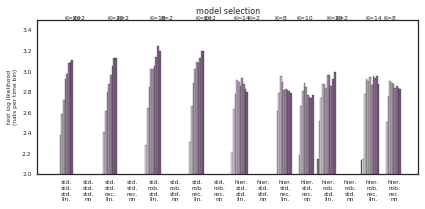

In [123]:
plt.figure(figsize=(6, 3))
ax = plt.subplot(111)
for index, (is_hierarchical, is_robust, is_recurrent, is_nn) in \
        enumerate(it.product(*([(False, True)] * 4))):

    models = []
    llss = []
    hlls = []
    z_smplss = []

    group_name = "{}_{}_{}_{}".format(
        "hier" if is_hierarchical else "nohier",
        "rob" if is_robust else "norob",
        "rec" if is_recurrent else "norec",
        "nn" if is_nn else "linear"
    )
    
    human_name = "{}\n{}\n{}\n{}".format(
        "hier." if is_hierarchical else "std.",
        "rob." if is_robust else "std.",
        "rec." if is_recurrent else "std.",
        "nn" if is_nn else "lin."
    )
    
    hlls = results[group_name][-1]
    best_index = results[group_name][1]
    if is_nn:
        hlls = np.concatenate(([np.nan], hlls))
        best_index += 1
    
    plot_likelihoods(index, 
                     Ks, 
                     hlls, 
                     best_index, 
                     human_name, 
                     axs=ax,
                     baseline=baseline_hll)
    

ax.set_ylim(2., 3.5)    
plt.tight_layout()

plt.savefig(os.path.join(fig_dir, "dimensionality.pdf"))

# Load the results of the best model fit

In [124]:
best_model_name = "hier_rob_rec_8_nn_full"
with open(os.path.join(results_dir, best_model_name + ".pkl"), "rb") as f:
    best_model, lls, hll, z_smpls = pickle.load(f)

In [125]:
# Compute the expected states
rslds_E_zs = []
for s in best_model.states_list:
    s.E_step()
    rslds_E_zs.append(s.expected_states)

# Relabel by usage
from pyhsmm.util.general import relabel_by_usage
rslds_zs, rslds_iperm = \
relabel_by_usage([np.argmax(E_z, axis=1) for E_z in rslds_E_zs],
                 return_mapping=True)

perm = np.argsort(rslds_iperm)
hier_dynamics_distns = [best_model.obs_distns[i] for i in perm]
dynamics_distns = [dd.regressions[-1] for dd in hier_dynamics_distns]
print("State usage:")
print(best_model.state_usages[perm])

State usage:
[0.2595269  0.18275585 0.16929158 0.0940646  0.09233525 0.09048237
 0.0680625  0.04348095]


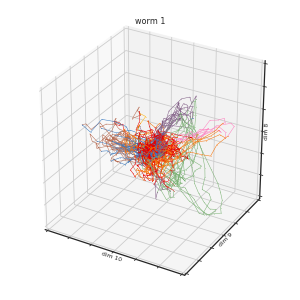

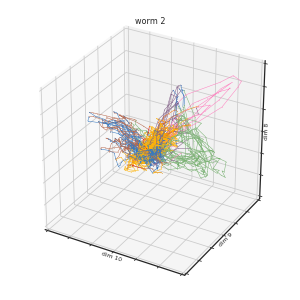

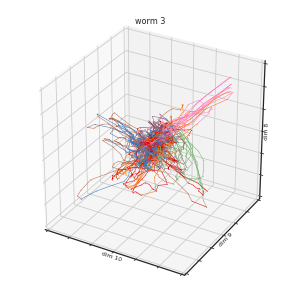

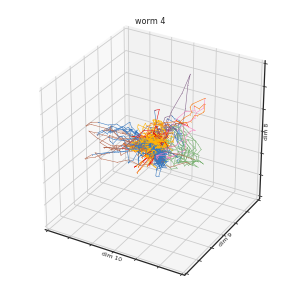

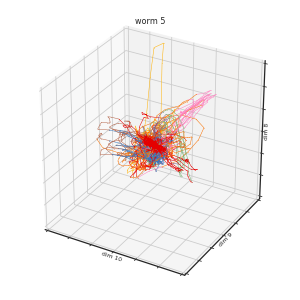

In [126]:
for i in range(N_worms):
    zplt.plot_3d_continuous_states(xtrains[i], rslds_zs[i], colors,
                              figsize=(4, 4),
                              # title="LDS Worm {} States (ARHMM Labels)".format(i + 1),
                              title="worm {}".format(i + 1),
                              results_dir=fig_dir,
                              filename="x_3d_{}.pdf".format(i + 1),
                              lim=3,
                              lw=.5,
                              inds=(9,8,7))


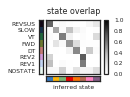

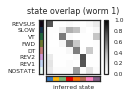

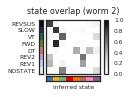

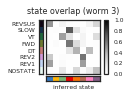

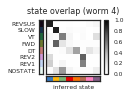

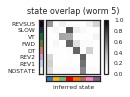

In [127]:
zplt.plot_state_overlap(rslds_zs, [ztr[1:] for ztr in z_trues],
                        z_key=z_key,
                        z_colors=zimmer_colors,
                        results_dir=fig_dir)


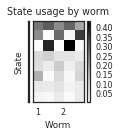

In [128]:
zplt.plot_state_usage_by_worm_matrix(rslds_zs,
                                     results_dir=fig_dir)

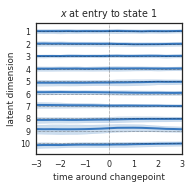

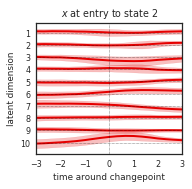

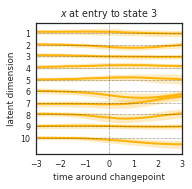

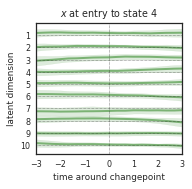

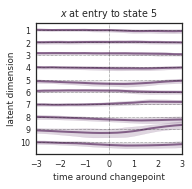

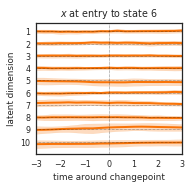

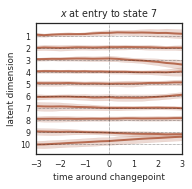

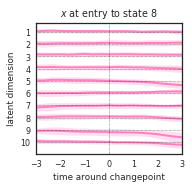

In [65]:
zplt.plot_x_at_changepoints(rslds_zs, xs,
                            colors=colors,
                            basename="x_cp",
                            results_dir=fig_dir)

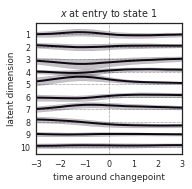

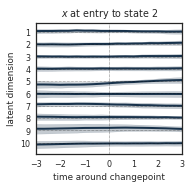

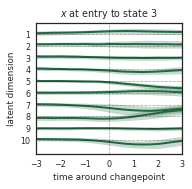

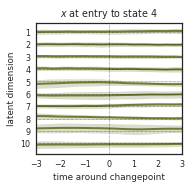

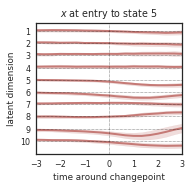

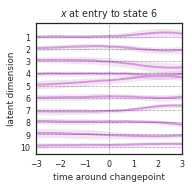

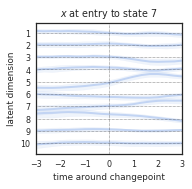

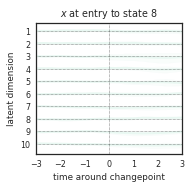

In [21]:
zplt.plot_x_at_changepoints(z_trues, xs,
                            colors=zimmer_colors,
                            basename="x_cp_zimmer",
                            results_dir=fig_dir)

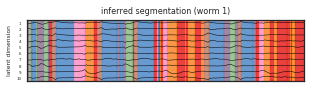

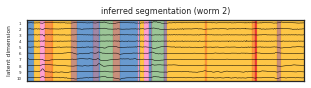

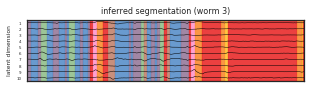

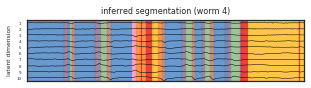

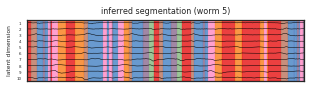

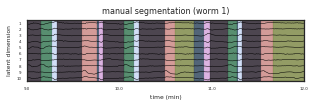

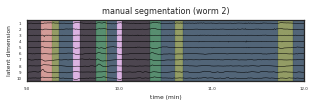

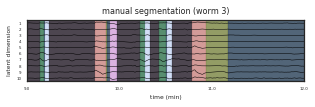

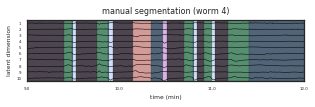

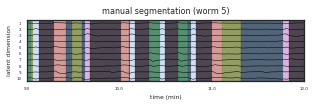

In [129]:
plot_slice = (9 * 60 * 3, 12 * 60 * 3)
zplt.plot_latent_trajectories_vs_time(xs, rslds_zs,
                                      plot_slice=plot_slice,
                                      show_xticks=False,
                                      title="inferred segmentation",
                                      basename="x_segmentation",
                                      colors=colors,
                                      results_dir=fig_dir)

zplt.plot_latent_trajectories_vs_time(xs, z_trues,
                                      plot_slice=plot_slice,
                                      title="manual segmentation",
                                      basename="x_segmentation_zimmer",
                                      colors=zimmer_colors,
                                      results_dir=fig_dir)

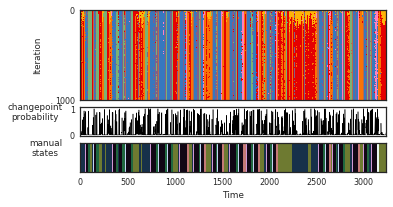

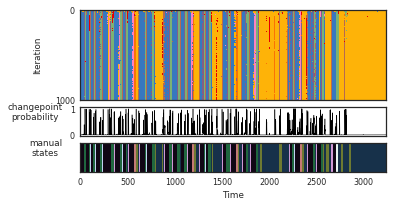

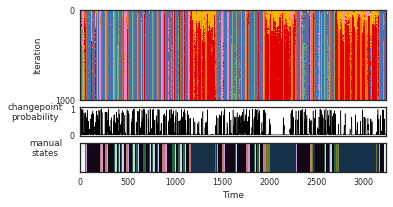

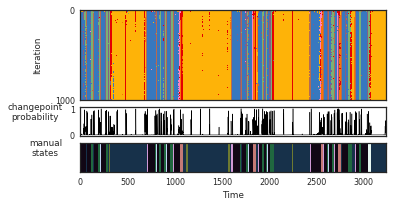

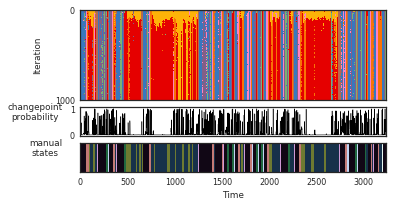

In [130]:
from pyhsmm.util.general import relabel_by_permutation
for i in range(N_worms):
    zplt.plot_changepoint_prs(
        np.array([relabel_by_permutation(z, rslds_iperm) for z in z_smpls[i]]),
        z_trues[i],
        true_colors=zimmer_colors,
        true_cmap=gradient_cmap(zimmer_colors),
        filepath=os.path.join(fig_dir, "z_smpls_{}.pdf".format(i)))


# Simulate some data

In [131]:
def make_latent_states_movie(x, z, filename, fps=60):
    T = x.shape[0]
    lw = 0.75
    lim = 3

    fig = plt.figure(figsize=(1.2, 1.2))
    ax = fig.add_subplot(111, projection="3d")

    point = ax.plot([x[0,0]], [x[0, 1]], [x[0,2]], 'ko', markersize=3)[0]
    point.set_zorder(1000)
    paths = [x[:1]]
    path_handles = [ax.plot([x[0,0]], [x[0, 1]], [x[0,2]], '-', color=colors[z[0]], lw=lw)[0]]

    ax.set_xlabel("dim 1", labelpad=-18, fontsize=6)
    ax.set_ylabel("dim 2", labelpad=-18, fontsize=6)
    ax.set_zlabel("dim 3", labelpad=-18, fontsize=6)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    if lim is not None:
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_zlim(-lim, lim)

    plt.tight_layout(pad=0.1)

    def _draw(t):
        assert t > 0
        
        # Update point
        point.set_data(x[t:t+1, 0], x[t:t+1, 1])
        point.set_3d_properties(x[t:t+1, 2])

        # Update paths
        if z[t] == z[t-1]:
            paths[-1] = np.row_stack((paths[-1], x[t:t+1]))
            path_handles[-1].set_data(paths[-1][:,0], paths[-1][:, 1])
            path_handles[-1].set_3d_properties(paths[-1][:, 2])
        else:
            paths.append(x[t-1:t+1])
            path_handles.append(ax.plot(paths[-1][:, 0],
                                        paths[-1][:, 1],
                                        paths[-1][:, 2],
                                        '-',
                                        color=colors[z[t]],
                                        lw=lw)[0])

    import matplotlib.animation as manimation
    FFMpegWriter = manimation.writers['ffmpeg']
    metadata = dict(title='probability vs space')
    writer = FFMpegWriter(fps=fps, bitrate=1024, metadata=metadata)
    with writer.saving(fig, os.path.join(mov_dir, filename), 300):
        # for t in tqdm(range(x.shape[0])):
        for t in tqdm(range(1, T)):
            _draw(t)
            writer.grab_frame()


In [132]:
from pyhsmm.util.general import relabel_by_permutation

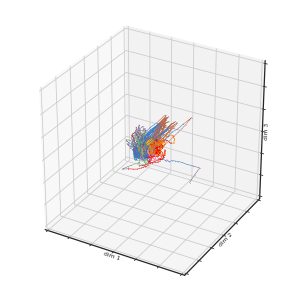

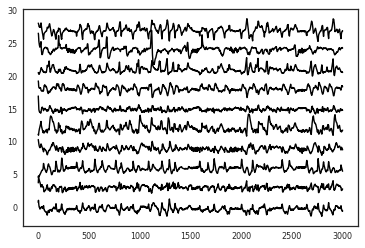

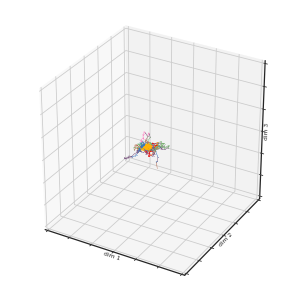

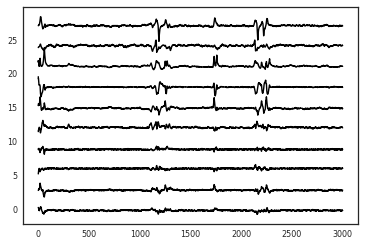

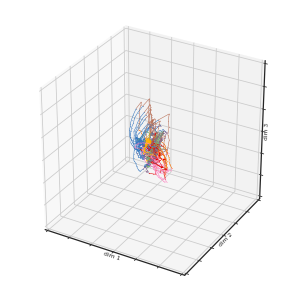

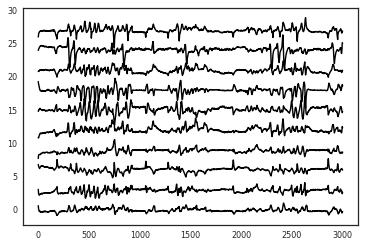

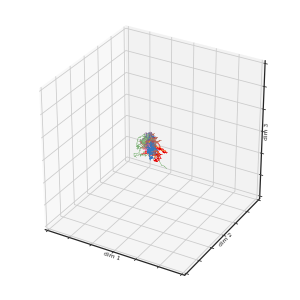

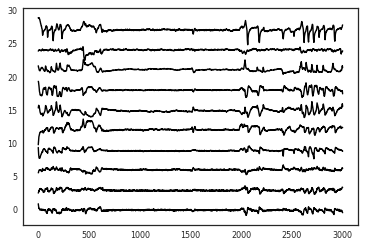

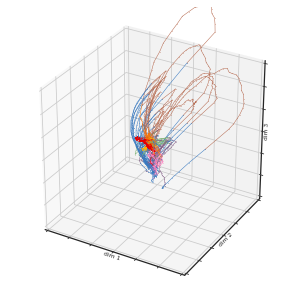

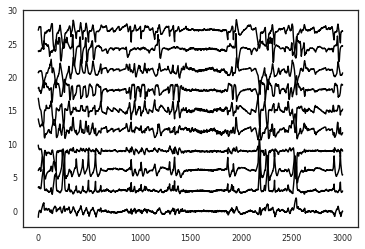

In [134]:
np.random.seed(0)

T_sim = 3000
for group in range(N_worms):
    x_sim, z_sim = best_model.generate(T=T_sim, with_noise=True, group=group, tau=0, noise_scale=0.05)
    z_sim = relabel_by_permutation(z_sim, rslds_iperm)

    zplt.plot_3d_continuous_states(x_sim, z_sim, colors,
                              figsize=(4, 4),
                              results_dir=fig_dir,
                              filename="x_rslds_gen_3d_{}.pdf".format(group + 1),
                              lim=3,
                              lw=.5)
    
    # Make a movie of the simulated data
#     make_latent_states_movie(x_sim, z_sim, "rslds_sample_{}.mp4".format(group), fps=90)
    
    # Plot the simulated trajectories
    plt.figure()
    plt.plot(np.arange(T_sim), x_sim + np.arange(10) * 3, '-k')
    
    # Project into neural space
    y_sim = x_sim.dot(C[:,:-1].T) + C[:,-1]
    sigma_obs = np.diag(lds_results['best_model'].sigma_obs[group])
    y_sim_noise = y_sim + np.sqrt(sigma_obs) * np.random.randn(T_sim, D_obs)

#     for neuron in neuron_names:
#         plot_simulated_data(y_sim_noise, y_sim, group, neuron)
#         plt.close("all")